In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np, math

from spherical_geometry.great_circle_arc import *
from spherical_geometry.vector import *

plt.rcParams.update({'font.size': 14})


In [2]:

def draw_basics(ax, Basic_Points, plot_meridian=True, plot_horizon=True, plot_equator=True):

    T, Zenith, P, N, E, S, W = Basic_Points
    
    n_points = 100
    n_half = int(n_points/2)
    phi = np.linspace(0, 2*np.pi, n_points)

    ## The Meridian
    if plot_meridian:
        x = np.cos(phi)
        y = np.zeros(n_points)
        z = np.sin(phi)
        ax.plot(x, y, z, c='k', lw=1) 

    ## The Ground Circle
    if plot_horizon:
        x = np.cos(phi)
        y = np.sin(phi)
        z = np.zeros(n_points)
        ax.plot(x[:n_half], y[:n_half], z[:n_half], c='k', lw=1, ls='--')
        ax.plot(x[n_half:], y[n_half:], z[n_half:], c='k', lw=1, ls='-')

    ## The Celestial Equator
    if plot_equator:
        x = np.cos(phi)
        y = np.sin(phi)
        z = np.zeros(n_points)

        lon, lat = vector_to_lonlat(P[0], P[1], P[2], degrees=False)
        X, Y, Z = rotate_around(x, y, z, E[0], E[1], E[2], theta=lat-np.radians(90), degrees=False)
        ax.plot(X[0:n_half], Y[0:n_half], Z[0:n_half], c='k', lw=1, ls='--')
        ax.plot(X[n_half:], Y[n_half:], Z[n_half:], c='k', lw=1, ls='-')


def plot_labels(ax, Basic_Points, labels='TZPNESW'):

    T, Zenith, P, N, E, S, W = Basic_Points
    pt = 10
    
    if 'T' in labels: ## 'Telescope'; Center of All circles
        ax.scatter(0, 0, 0, c='k', s=pt)
        ax.text(0.02, 0, 0, 'T')
        
    if 'Z' in labels: ## Zenith
        ax.scatter(0, 0, 1, c='r', s=pt) 
        ax.text(0.0, 0, 1.04, 'Z')
        
    if 'P' in labels: ## North Celestial Pole
        ax.scatter(P[0], P[1], P[2], c='r', s=pt)
        ax.text(P[0]-0.05, P[1], P[2]+0.03, 'P')            
            
    if 'N' in labels:  
        ax.scatter(N[0], N[1], N[2], c='k', s=pt)
        ax.text(-1.1, -0.25, 0, 'N')
    if 'E' in labels:
        ax.scatter(E[0], E[1], E[2], c='k', s=pt)
        ax.text(-0.08, 1.3, 0, 'E')
    if 'S' in labels:
        ax.scatter(S[0], S[1], S[2], c='k', s=pt)
        ax.text(1.02, -0.25, 0, 'S')
    if 'W' in labels:
        ax.scatter(W[0], W[1], W[2], c='k', s=pt)
        ax.text(0.018, -1.5, 0, 'W')


def plot_arc(A, B, ax, c='k', lw=1, ls='-'):
    
    arc = interpolate(A, B)
    ax.plot(arc[:,0], arc[:,1], arc[:,2], c=c, lw=lw, ls=ls)


def plot_line(A, B, ax, c='k', lw=1, ls='--'):

    ax.plot([A[0],B[0]], [A[1],B[1]], [A[2],B[2]], c=c, lw=lw, ls=ls)


def rotate_to_horizon(A0, B0):

    '''
    Given a pair of points A0, B0, find a rotation (composed of 4 simple rotations) matrix that simultaneously maps A0, B0 to horizon.
    B0 will always be mapped to the Horizon South, and A0 on the West half of Horizon.
    Return the projected points (A3, B3) on Horizon, and the inverse matrix that brings them back to A0, B0.

    Parameters:
    
        A0, B0: (x, y, z) triples or 1x3 arrays
    
            The endpoints of the great circle arc. It is assumed thats these points are already normalized.
    
    Returns:
    
        rot_inv: 3x3 array
        
            The inverse matrix of the rotations. It maps A3, B3 on Horizon back to A0, B0.
            
        A3, B3: array(x, y, z): triples
    
            The points mapped from A0, B0 to horizon by 4 rotations.

    '''

    ######## rotation around z axis to put B0 -> B1, B1 on South side of meridian
    lon, lat = vector_to_lonlat(B0[0], B0[1], B0[2], degrees=False)
    cos = np.cos(lon)
    sin = np.sin(lon)
    
    rotz = np.array(
        [[cos, sin, 0],
         [-sin, cos, 0],
         [0, 0, 1]]
    )
    
    rotz_inv = np.array(
        [[cos, -sin, 0],
         [sin, cos, 0],
         [0, 0, 1]]
    )
    
    
    A1 = rotz@A0
    B1 = rotz@B0
    
    ######## rotation around y axis to put B1 -> B2, B2 at Ground South
    lon, lat = vector_to_lonlat(B1[0], B1[1], B1[2], degrees=False)
    cos = np.cos(lat)
    sin = np.sin(lat)
    roty = np.array(
        [[cos, 0, sin],
         [0, 1, 0],
         [-sin, 0, cos]]
    )
    roty_inv = np.array(
        [[cos, 0, -sin],
         [0, 1, 0],
         [sin, 0, cos]]
    )
    
    A2 = roty@A1
    B2 = roty@B1

    
    ######## rotation around x axis to put A2 -> A3, A3 on West half of Horizon
    rot_angle = np.arctan2(A2[2], -A2[1])
    cos = np.cos(rot_angle)
    sin = np.sin(rot_angle)
    rotx = np.array(
        [[1, 0, 0],
         [0, cos, -sin],
         [0, sin, cos]]
    )
    
    rotx_inv = np.array(
        [[1, 0, 0],
         [0, cos, sin],
         [0, -sin, cos]]
    )
    
    A3 = rotx@A2
    B3 = rotx@B2     ## B3 should be identical to B2

    rot_inv = rotz_inv@roty_inv@rotx_inv

    return rot_inv, A3, B3


def extrapolate(A0, B0, extend_length=30, steps=50):

    '''
    extrapolate an arc that goes from A0 to B0 and continues by extend_length [degrees].
    First rotate A0 and B0 to horizon, with B0 aligned at Ground South.
    Then extend the arc on horizon.
    Finally rotate the extended arc back onto sky.

    '''
    
    rot_inv, A3, B3 = rotate_to_horizon(A0, B0)

    ## extend from A3 to B3; lon of A3 in [pi, 2pi]
    lon, lat = vector_to_lonlat(A3[0], A3[1], A3[2], degrees=False)
    phi = np.linspace(lon, 2*np.pi+np.radians(extend_length), steps)
    
    X = np.cos(phi)
    Y = np.sin(phi)
    Z = np.zeros(steps)
    
    arc_horizon = np.array([X, Y, Z])
    arc_extend = (rot_inv@arc_horizon).T
    
    return arc_extend


def perpendicular_arc(A0, B0, arc_length=30, steps=50, flip_direction=False):

    '''
    Find an arc that is perpendicular to the arc that goes from A0 to B0.
    First rotate A0 and B0 to horizon, with B0 aligned at Ground South.
    Then draw an arc along the meridian, starting at B0.
    Finally rotate the arc back onto sky.

    '''

    rot_inv, A3, B3 = rotate_to_horizon(A0, B0)
    
    phi = np.linspace(0, np.radians(arc_length), steps)

    X = np.cos(phi)
    Y = np.zeros(steps)
    Z = np.sin(phi)
 
    if flip_direction:
        Z *= -1
        
    arc_horizon = np.array([X, Y, Z])
    arc_perpendicular = (rot_inv@arc_horizon).T

    return arc_perpendicular


def point_on_equator(P, HA=0):

    '''
    Find the (x,y,z) coordinates of a point on the equator with an Hour Angle of HA degrees.
    '''

    HA = np.radians(HA)
    Q = np.array([np.cos(HA), -np.sin(HA), 0])   ## put the point on Horizon first

    lon, lat = vector_to_lonlat(P[0], P[1], P[2], degrees=False)
    cos = np.cos(np.pi/2-lat)
    sin = np.sin(np.pi/2-lat)
    roty = np.array(
        [[cos, 0, -sin],
         [0, 1, 0],
         [sin, 0, cos]]
    )
    
    Q = (roty@Q).T

    return Q


def calc_ecliptic(P, HA=0, steps=50):

    '''
    Calculate the ecliptic circle with the Aries at an Hour Angle of HA degrees.
    Step 1, rotate the Equator to Horizon.
    Step 2, draw a circle on the equator (Horizon)
    Step 3, rotate the circle by 23.5, the angle between Equator and Ecliptic
    Step 4, rotate the circle by HA angles.
    Step 5, rotate the circle by the inverse rotation matrix from Horizon to Equator.
    '''

    ########## first step ###########
    A = point_on_equator(P, HA=0)
    B = point_on_equator(P, HA=90)
    rot_inv, A3, B3 = rotate_to_horizon(A, B)

    ######## second step ############
    phi = np.linspace(0, 2*np.pi, steps)

    X = np.cos(phi)
    Y = np.sin(phi)
    Z = np.zeros(steps)
    circle_horizon = np.array([X, Y, Z])


    ####### third step #############
    angle_equator_ecliptic = np.radians(23.5)
    cos = np.cos(angle_equator_ecliptic)
    sin = np.sin(angle_equator_ecliptic)

    roty = np.array(
        [[cos, 0, -sin],
         [0, 1, 0],
         [sin, 0, cos]])

    cicle_ecliptic = roty@circle_horizon


    ####### fourth step #############
    if HA != 0:
        
        cos = np.cos(np.radians(HA))
        sin = np.sin(np.radians(-HA))

        rotz = np.array(
        [[cos, sin, 0],
         [-sin, cos, 0],
         [0, 0, 1]])

        cicle_ecliptic = rotz@cicle_ecliptic

    ####### last step #############
    cicle_ecliptic = rot_inv@cicle_ecliptic
    
    return cicle_ecliptic.T


def project_to_equator(P, G, HA1=0, HA2=180):

    '''
    Project a point G onto the Equator.
    First extend the arc PG to go beyond the equator. 90 degrees of extension is safe.
    Then Define an arc AB on the equator.
    Finally find the Intersection of AB and the (PG extension) as the projection of G.
    '''
    
    ## Find an end point on the extension of arc PG that goes past the equator
    arc = extrapolate(P, G, extend_length=90)
    arc_end = arc[-1,:]

    ## Define two points on the equator
    A = point_on_equator(P, HA=HA1)
    B = point_on_equator(P, HA=HA2)
    
    ## find projection of G on equator as intersection of PG and AB
    GE = intersection(G, arc_end, A, B)

    return GE


In [3]:

T = np.array([0,0,0])       ## Telescope; Center of All Circles
Z = np.array([0,0,1])       ## Zenith
        
N = np.array([-1,0, 0])     ## Ground North
E = np.array([0, 1, 0])     ## Ground East
S = np.array([1, 0, 0])     ## Ground South
W = np.array([0,-1, 0])     ## Ground West

lat = np.radians(90+23.5)   ## put the horizon to align with the ecliptic
x = np.cos(lat)
y = 0
z = np.sin(lat)
P = np.array([x, y, z])     ## Celestial North Pole

lat = np.radians(270+23.5)
x = np.cos(lat)
y = 0
z = np.sin(lat)
SP = np.array([x, y, z])    ## Celestial South Pole

Basic_Points = [T, Z, P, N, E, S, W]


## Plot the Physical Earth

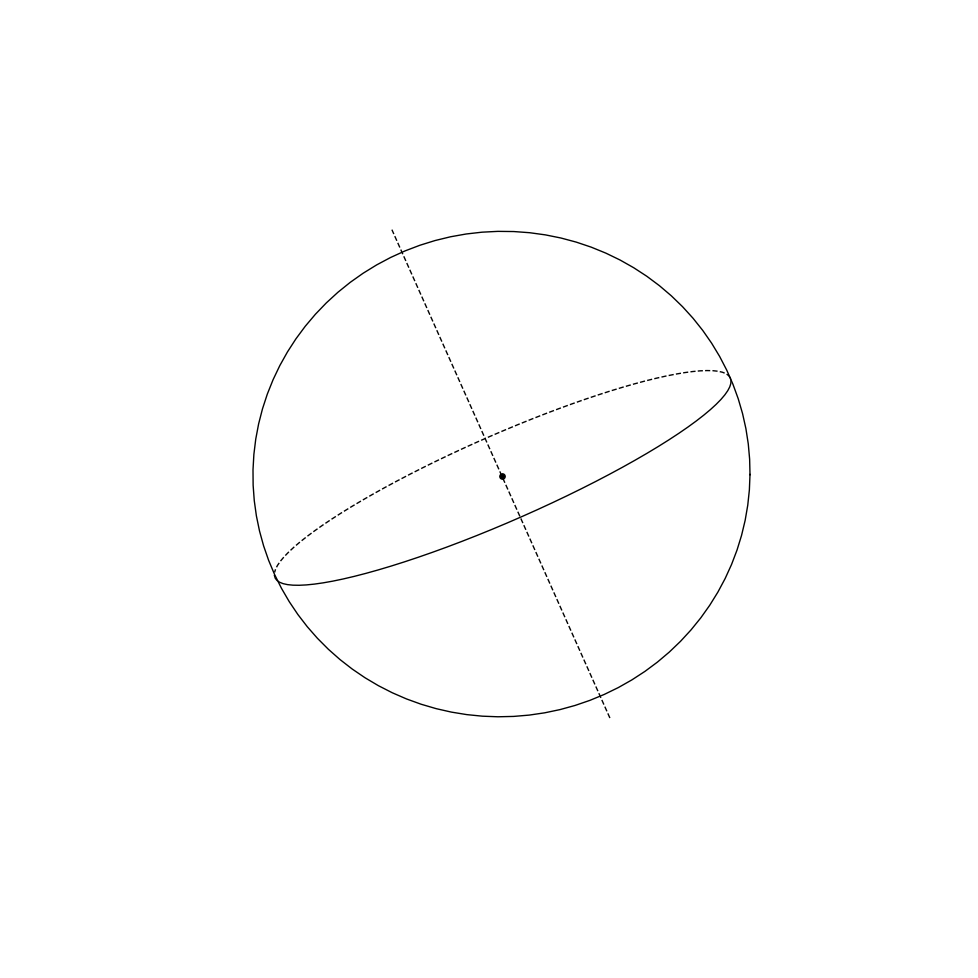

In [4]:

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(0,0,0, s=15, c='k')

draw_basics(ax, Basic_Points, plot_horizon=False)
plot_line(1.1*SP, 1.1*P, ax, ls='--')

ax.view_init(10, -92)
ax.axis('off')
ax.set_box_aspect([1,1,1])

plt.tight_layout()
plt.show()
#plt.savefig('Earth.png')


## Move to a different latitude for better illustration

In [5]:

lat = np.radians(130)   ## latitude is actually 50
x = np.cos(lat)
y = 0
z = np.sin(lat)
P = np.array([x, y, z])

Basic_Points = [T, Z, P, N, E, S, W]


## Basics of the Celestial Sphere

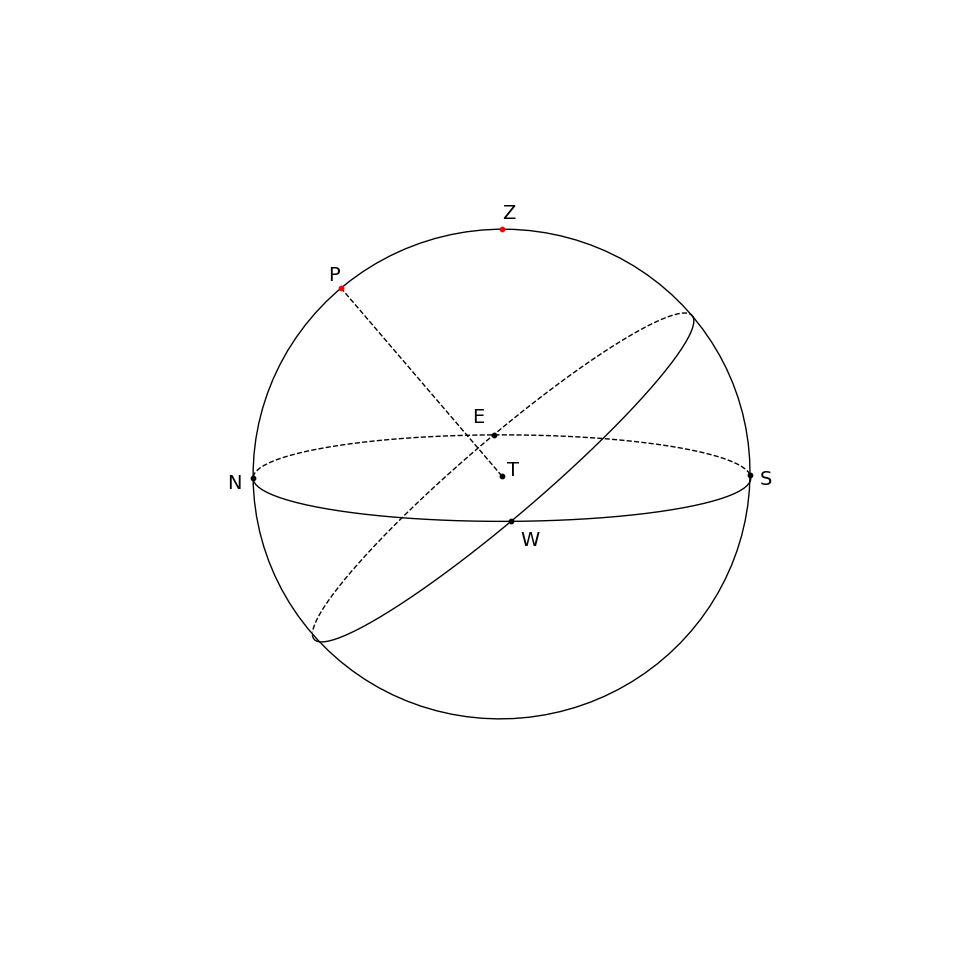

In [6]:

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

draw_basics(ax, Basic_Points)
plot_labels(ax, Basic_Points)

plot_line(T, P, ax, ls='--')
# plot_line(T, Z, ax, ls='--')
# plot_line(T, N, ax, ls='--')

ax.view_init(10, -92)
ax.axis('off')
ax.set_box_aspect([1,1,1])

plt.tight_layout()
plt.show()
#plt.savefig('basic_spheres.png')


## The Horizontal Coordinate System

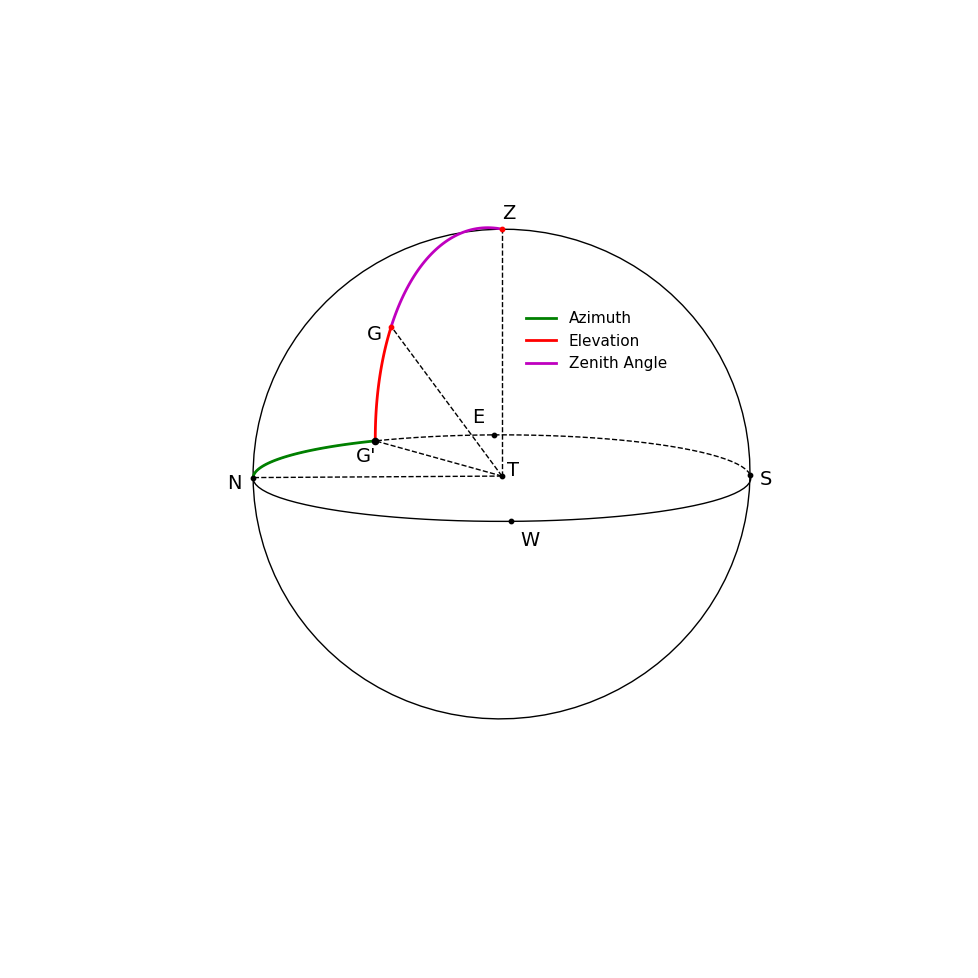

In [7]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

draw_basics(ax, Basic_Points, plot_equator=False)
plot_labels(ax, Basic_Points, labels='TZNESW')


G = lonlat_to_vector(120, 30)   ## an Object on sky
GH = lonlat_to_vector(120, 0)   ## projection of object on horizon

ax.scatter(G[0], G[1], G[2], s=10, c='r')
ax.text(G[0]-0.1, G[1]-0.05, G[2]-0.05, 'G')

ax.scatter(GH[0], GH[1], GH[2], c='k')
ax.text(GH[0]-0.08, GH[1]-0.05, GH[2]-0.08, "G\'")

#plot_arc(Z, GH, ax)
plot_line(T, G, ax, ls='--')
plot_line(T, GH, ax, ls='--')
plot_line(T, Z, ax, ls='--')
plot_line(T, N, ax, ls='--')


plot_arc(N, GH, ax, c='g', lw=2, ls='-')
plot_arc(G, GH, ax, c='r', lw=2, ls='-')
plot_arc(G, Z, ax, c='m', lw=2, ls='-')
ax.plot([], [], c='g', lw=2, ls='-', label='Azimuth')
ax.plot([], [], c='r', lw=2, ls='-', label='Elevation')
ax.plot([], [], c='m',lw=2, ls='-', label='Zenith Angle')

ax.legend(fontsize=11, bbox_to_anchor=(0.7, 0.7), frameon=False)
ax.view_init(10, -92)
ax.axis('off')
ax.set_box_aspect([1,1,1])

plt.tight_layout()
plt.show()
#plt.savefig('Az_El.png')


## The Equatorial Coordinate System

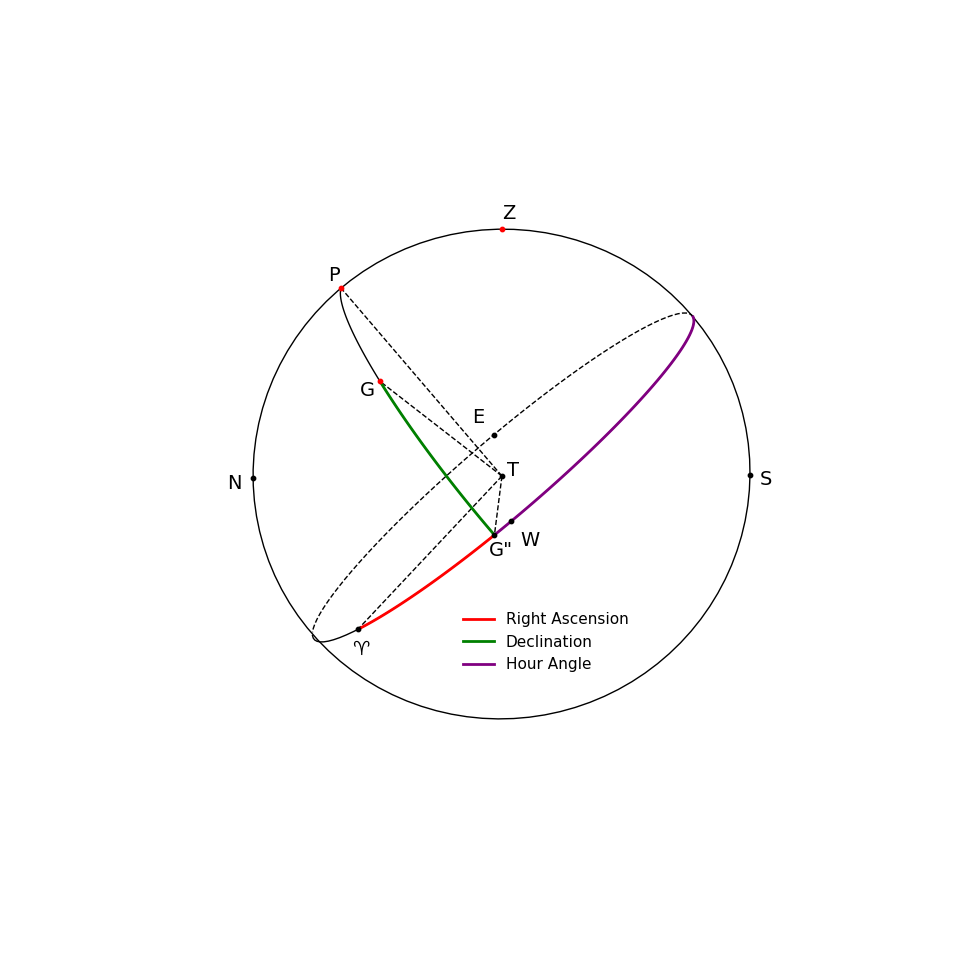

In [8]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

draw_basics(ax, Basic_Points, plot_horizon=False)
plot_labels(ax, Basic_Points)

G = lonlat_to_vector(235, 30)                ## an Object on sky
GE = project_to_equator(P, G)     ## projection of object on equator

ax.scatter(G[0], G[1], G[2], s=10, c='r')
ax.text(G[0]-0.08, G[1]-0.05, G[2]-0.05, 'G')

ax.scatter(GE[0], GE[1], GE[2], s=10, c='k')
ax.text(GE[0]-0.02, GE[1], GE[2]-0.08, 'G"')
plot_arc(P, GE, ax)

## mark the vernal equinox
Aries = point_on_equator(P, HA=140)
ax.scatter(Aries[0], Aries[1], Aries[2], s=10, c='k')
ax.text(Aries[0]-0.02, Aries[1], Aries[2]-0.1, u'♈︎')

## Intersection of Equator and Meridian on South side
SE = point_on_equator(P, HA=0)

plot_line(T, P, ax, ls='--')
plot_line(T, G, ax, ls='--')
plot_line(T, GE, ax, ls='--')
plot_line(T, Aries, ax, ls='--')

plot_arc(Aries, GE, ax, c='r', lw=2, ls='-')
plot_arc(G, GE, ax, c='g', lw=2, ls='-')
plot_arc(SE, GE, ax, c='purple', lw=2, ls='-')
ax.plot([], [], c='r', lw=2, ls='-', label='Right Ascension')
ax.plot([], [], c='g', lw=2, ls='-', label='Declination')
ax.plot([], [], c='purple', lw=2, ls='-', label='Hour Angle')

ax.legend(fontsize=11, bbox_to_anchor=(0.66, 0.34), frameon=False)

ax.view_init(10, -92)
ax.axis('off')
ax.set_box_aspect([1,1,1])

plt.tight_layout()
plt.show()
#plt.savefig('Ra_Dec.png')


## A Few Ecliptic Circles

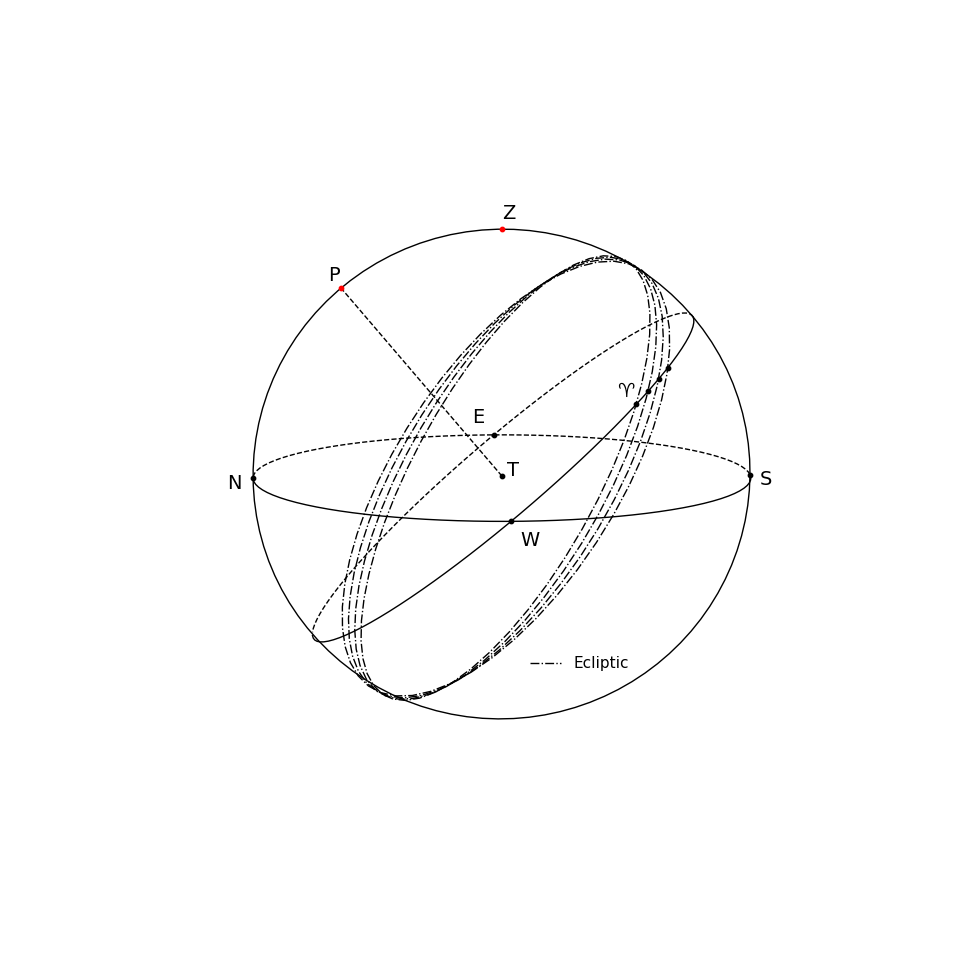

In [9]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

draw_basics(ax, Basic_Points)
plot_labels(ax, Basic_Points)

for ha in [35, 40, 45, 50]:
    arc = calc_ecliptic(P, HA=ha, steps=50)
    ax.plot(arc[:,0], arc[:,1], arc[:,2], c='k', lw=1, ls='-.')
    
    Aries = point_on_equator(P, HA=ha)
    ax.scatter(Aries[0], Aries[1], Aries[2], s=10, c='k')
    
## mark the last vernal equinox
ax.text(Aries[0]-0.07, Aries[1], Aries[2]+0.03, u'♈︎')


plot_line(T, P, ax, ls='--')
ax.plot([], [], lw=1, c='k', ls='-.', label='Ecliptic')
ax.legend(fontsize=11, bbox_to_anchor=(0.66, 0.34), frameon=False)

ax.view_init(10, -92)
ax.axis('off')
ax.set_box_aspect([1,1,1])

plt.tight_layout()
#plt.savefig('Equinox.png')


## Define A Spherical Triangle

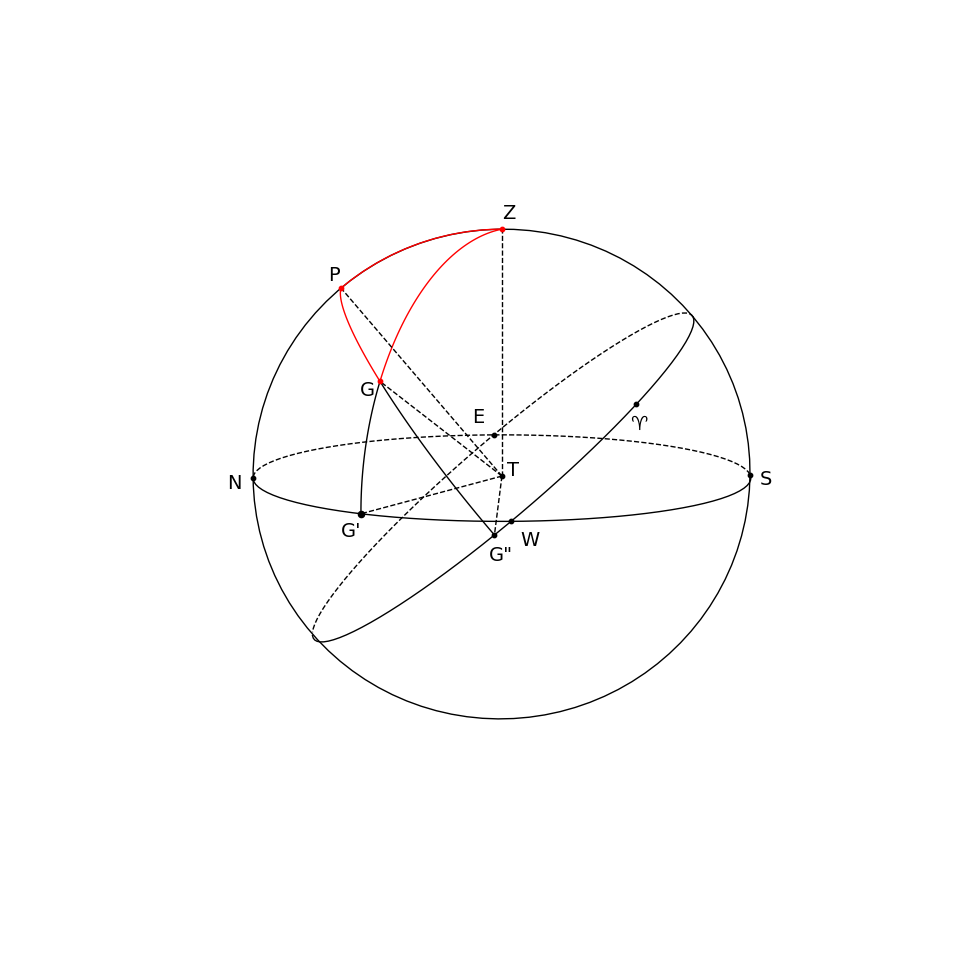

In [10]:

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

draw_basics(ax, Basic_Points)
plot_labels(ax, Basic_Points)

G = lonlat_to_vector(235, 30)                ## an Object on sky
GH = lonlat_to_vector(235, 0)                ## projection of object on horizon
GE = project_to_equator(P, G)                ## projection of object on equator

ax.scatter(G[0], G[1], G[2], s=10, c='r')
ax.text(G[0]-0.08, G[1]-0.05, G[2]-0.05, 'G')

ax.scatter(GH[0], GH[1], GH[2], c='k')
ax.text(GH[0]-0.08, GH[1]-0.05, GH[2]-0.08, "G\'")

ax.scatter(GE[0], GE[1], GE[2], s=10, c='k')
ax.text(GE[0]-0.02, GE[1], GE[2]-0.1, 'G"')

ax.scatter(Aries[0], Aries[1], Aries[2], s=10, c='k')
ax.text(Aries[0]-0.02, Aries[1], Aries[2]-0.1, u'♈︎')

plot_arc(P, G, ax, c='r', lw=1, ls='-')
plot_arc(Z, G, ax, c='r', lw=1, ls='-')
plot_arc(Z, P, ax, c='r', lw=1, ls='-')

plot_arc(G, GE, ax, c='k', lw=1, ls='-')
plot_arc(G, GH, ax, c='k', lw=1, ls='-')

plot_line(T, G, ax, ls='--')
plot_line(T, P, ax, ls='--')
plot_line(T, GE, ax, ls='--')
plot_line(T, GH, ax, ls='--')
plot_line(T, Z, ax, ls='--')


ax.view_init(10, -92)
ax.axis('off')
ax.set_box_aspect([1,1,1])

plt.tight_layout()
plt.show()
#plt.savefig('the_triangle.png')


## Adding A shift for DCR

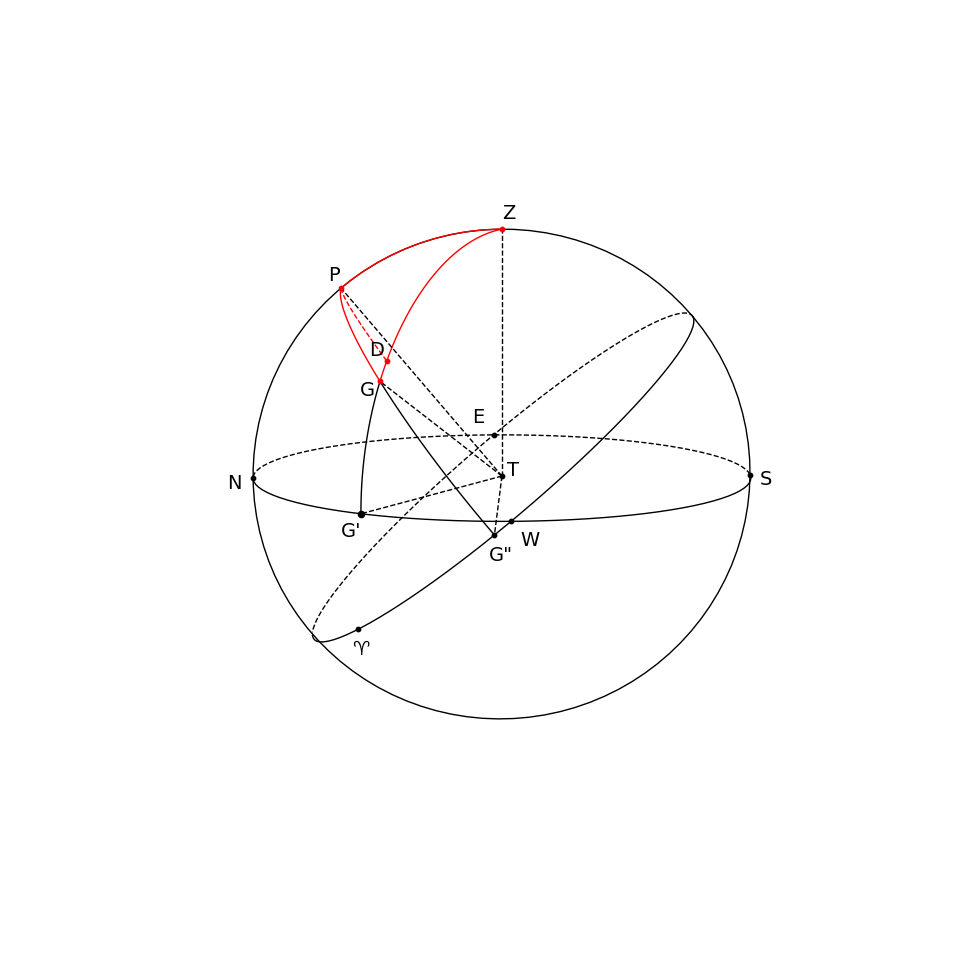

In [11]:

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

draw_basics(ax, Basic_Points)
plot_labels(ax, Basic_Points)

G = lonlat_to_vector(235, 30)                ## an Object on sky
GH = lonlat_to_vector(235, 0)                ## projection of object on horizon
GE = project_to_equator(P, G)                ## projection of object on equator
D = lonlat_to_vector(235, 35)                ## DCR shifted position of G
Aries = point_on_equator(P, HA=140)          ## equinox

ax.scatter(G[0], G[1], G[2], s=10, c='r')
ax.text(G[0]-0.08, G[1]-0.05, G[2]-0.05, 'G')

ax.scatter(GH[0], GH[1], GH[2], c='k')
ax.text(GH[0]-0.08, GH[1]-0.05, GH[2]-0.08, "G\'")

ax.scatter(GE[0], GE[1], GE[2], s=10, c='k')
ax.text(GE[0]-0.02, GE[1], GE[2]-0.1, 'G"')

ax.scatter(D[0], D[1], D[2], s=10, c='r')
ax.text(D[0]-0.07, D[1], D[2]+0.02, 'D')

ax.scatter(Aries[0], Aries[1], Aries[2], s=10, c='k')
ax.text(Aries[0]-0.02, Aries[1], Aries[2]-0.1, u'♈︎')

plot_arc(P, G, ax, c='r', lw=1, ls='-')
plot_arc(Z, G, ax, c='r', lw=1, ls='-')
plot_arc(Z, P, ax, c='r', lw=1, ls='-')
plot_arc(P, D, ax, c='r', lw=1, ls='--')

plot_arc(G, GE, ax, c='k', lw=1, ls='-')
plot_arc(G, GH, ax, c='k', lw=1, ls='-')

plot_line(T, G, ax, ls='--')
plot_line(T, P, ax, ls='--')
plot_line(T, GE, ax, ls='--')
plot_line(T, GH, ax, ls='--')
plot_line(T, Z, ax, ls='--')


ax.view_init(10, -92)
ax.axis('off')
ax.set_box_aspect([1,1,1])

plt.tight_layout()
plt.show()
#plt.savefig('DCR.png')


## Zoom-in on the Triangle

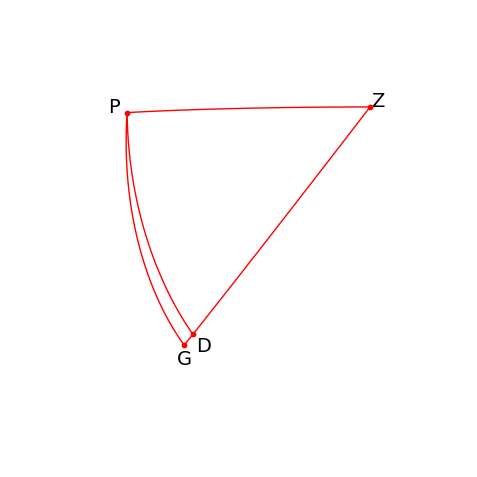

In [12]:

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')

plot_labels(ax, Basic_Points, labels='PZ')

G = lonlat_to_vector(235, 30)   ## an Object on sky
D = lonlat_to_vector(235, 35)   ## DCR shifted position of G

ax.scatter(G[0], G[1], G[2], s=10, c='r')
ax.text(G[0]-0.02, G[1]-0.06, G[2], 'G')

ax.scatter(D[0], D[1], D[2], s=10, c='r')
ax.text(D[0]+0.01, D[1]-0.05, D[2], 'D')

plot_arc(P, G, ax, c='r', lw=1, ls='-')
plot_arc(Z, G, ax, c='r', lw=1, ls='-')
plot_arc(Z, P, ax, c='r', lw=1, ls='-')
plot_arc(P, D, ax, c='r', lw=1, ls='-')


ax.view_init(90, -92)
ax.axis('off')
ax.set_box_aspect([1,1,1])

plt.tight_layout()
plt.show()
#plt.savefig('hint.png')
